# Лабораторная 1. Байесовская классификация.

## Задание1. Оценка нормального распределения


[2 балла] Выборка x1, x2, ..., xn была получена из одномерного нормального
распределения. Выведите формулы для оценки параметров нормального
распределения (среднее и среднеквадратическое отклонение) через метод
максимального правдоподобия.

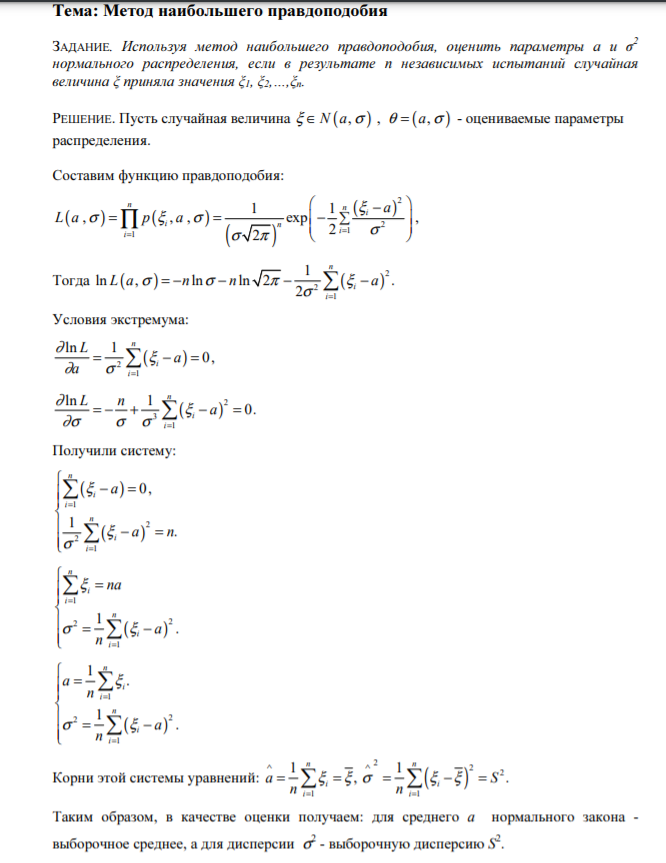

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def normal_dist(x, mean ,sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def create_norm_density(x):
    mean = np.mean(x)
    sd = np.std(x)

    pdf = normal_dist(x, mean, sd)
    return pdf

Text(0, 0.5, 'Probability Density')

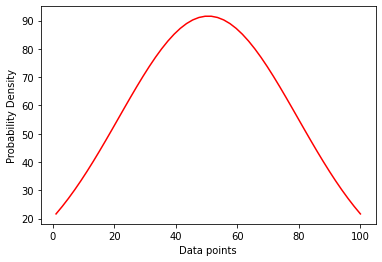

In [3]:
x = np.linspace(1, 100, 50)

pdf = create_norm_density(x)

plt.plot(x, pdf, color = 'red')
plt.xlabel('Data points')
plt.ylabel('Probability Density')

In [4]:
print(f"Среднее = {np.mean(x)}")
print(f"Отклонение = {np.std(x)}")

Среднее = 50.49999999999999
Отклонение = 29.1562469240106


## Задание2. Задача бинарной классификации

[6 баллов] Сгенерируйте выборку для задачи бинарной классификации: первый
класс из нормального распределения с параметрами μ = 0, σ = 1.0, а второй с
параметрами μ = 2.0, σ = 0.5. Сгенерируйте тренировочную выборку из этих
распределений -- по 20 точек для каждого класса, и тестовую выборку -- по 1000 точек для каждого класса. Визуализируйте тренировочную выборку и плотности распределения классов на одном графике.


### Генерация данных

In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [60]:
count_train_in_class = 20
count_test_in_class = 1000
parametrs = [[0.0, 1.0], [2.0, 0.5]]

Создадим класс для генерации нормального распределения с входными параметрами и построением графиков

In [61]:
class Gaussian:
  def __init__(self, mean, std, count):
    self.mean = mean
    self.std = std
    self.count = count
    self.X = self._linspace()
    self.dist_X = self._distribution()

  def get_linspace(self):
    return self.X

  def get_distribution(self):
    return self.dist_X

  def plot(self, legend_location="best"):
    title = "Gaussian Distribution"
    x_label = "x"
    y_label = "N(x|μ,σ)"
    legend_label = "μ={}, σ={}".format(self.mean, self.std)
    
    plt.title(title)
    plt.scatter(self.X, self.dist_X, label=legend_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=legend_location)
    
    return plt
  
  def _linspace(self):
    X = np.random.default_rng().normal(self.mean, self.std, self.count) 
    return X

  def _distribution(self):
    return 1./(np.sqrt(2*np.pi)*self.std)*np.exp(-0.5 * (1./self.std*(self.X - self.mean))**2)

In [62]:
def draw_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm)
  print(cm)

Создадим 2 тренировочных и 2 тестовых выборки

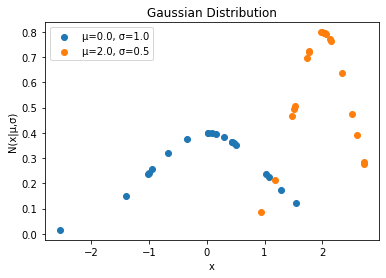

In [63]:
gauss1_train = Gaussian(parametrs[0][0], parametrs[0][1], count_train_in_class)
gauss2_train = Gaussian(parametrs[1][0], parametrs[1][1], count_train_in_class)
x_train1 = gauss1_train.get_linspace()
x_train2 = gauss2_train.get_linspace()
plot = gauss1_train.plot()
plot = gauss2_train.plot()
plot.show()

In [64]:
gauss1_test = Gaussian(parametrs[0][0], parametrs[0][1], count_test_in_class)
gauss2_test = Gaussian(parametrs[1][0], parametrs[1][1], count_test_in_class)
x_test1 = gauss1_test.get_linspace()
x_test2 = gauss2_test.get_linspace()

In [65]:
X_train = pd.concat([pd.DataFrame(x_train1, columns=["x"]), pd.DataFrame(x_train2, columns=["x"])]).reset_index().drop(["index"], axis=1)
y_train = np.array([0]*count_train_in_class + [1]*count_train_in_class)
X_test = pd.concat([pd.DataFrame(x_test1, columns=["x"]), pd.DataFrame(x_test2, columns=["x"])]).reset_index().drop(["index"], axis=1)
y_test = np.array([0]*count_test_in_class + [1]*count_test_in_class)

In [66]:
# функция построения матрицы ошибок
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', vmin=0, vmax=count_test_in_class, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    labels = ["First class", "Second class"]
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Встроенный в sklearn метод

[[851 149]
 [ 48 952]]


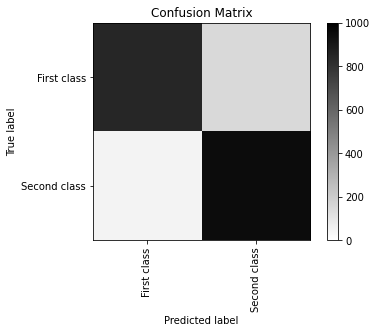

In [67]:
gnb_model = GaussianNB()
gnb_model = gnb_model.fit(X_train, y_train)
y_pred = gnb_model.predict(X_test)
draw_confusion_matrix(y_test, y_pred)

### Свой идеальный байесовский классификатор

Идеальный байесовский классификатор, который использует истинные
плотности распределения. Посчитайте ошибку на тесте. Почему она
получилась ненулевая? Можно ли сделать классификатор с нулевой
ошибкой?


In [68]:
Py = 1/2

def likehood(x, mean, s):
    return 1./(np.sqrt(2*np.pi)*s)*np.exp(-0.5 * (1./s*(x - mean))**2)


def ideal_naive_bayes(test):
    labels = []
    for x in test:
        result = [Py * likehood(x, parametrs[i][0], parametrs[i][1]) for i in [0, 1]]
        argmax = max(result)
        labels.append(result.index(argmax))
    return labels

[[853 147]
 [ 51 949]]


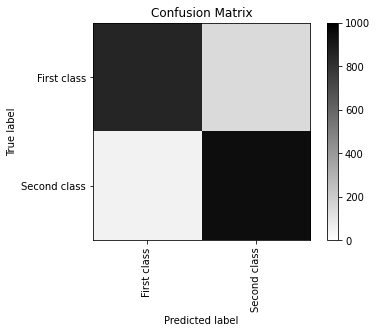

In [69]:
y_ideal_pred = ideal_naive_bayes(X_test.x)
draw_confusion_matrix(y_test, y_ideal_pred)

Он не дает максимальную точность, потому что если присмотреться к графикам выше, наши выборки пересекаются по X, а следовательно на таких местах и происходит ошибка. При создании непересекающихся множеств (например m1 = 0 и m2 = 10), мы получим 100%

### Окно Парзена-Розенблатта

Попробуем визуализировать для начала

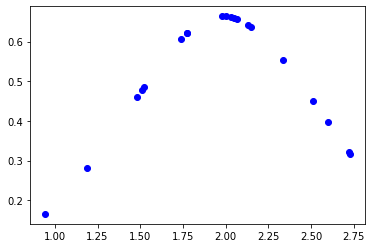

In [70]:
from scipy.stats import gaussian_kde
kde_sp = gaussian_kde(x_train2, bw_method=0.75)
y_sp = kde_sp.pdf(x_train2)
plt.scatter(x_train2, y_sp, color="blue")

In [71]:
def naive_bayses_parsen_rozenblad(window, train_x, train_y, test):
  kde_sp1 = gaussian_kde(x_train1, bw_method=window)
  kde_sp2 = gaussian_kde(x_train2, bw_method=window)
  
  labels = [0 if kde_sp1.pdf(x) > kde_sp2.pdf(x) else 1 for x in test]
  return labels

Max accuracy = 0.864 при window = 0.7
[[844 156]
 [ 39 961]]


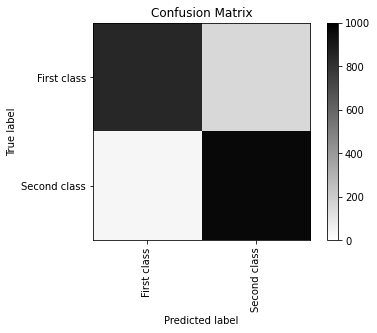

In [72]:
def get_accuracy(cm):
  accuracy = (cm[0][0] + cm[1][1]) / (cm[0][1] + cm[1][1] + cm[0][0] + cm[1][0])
  return accuracy

max_accuracy = -1
max_window = 0
for window in [0.1*i for i in range(1, 20)]:
  y_parsen_pred = naive_bayses_parsen_rozenblad(window, X_train.x, y_train, X_test.x)
  cm = confusion_matrix(y_test, y_parsen_pred)
  accuracy = get_accuracy(cm)
  if accuracy > max_accuracy:
    max_accuracy = accuracy
    max_window = window

print(f"Max accuracy = {accuracy} при window = {round(max_window, 2)}")
y_parsen_pred = naive_bayses_parsen_rozenblad(max_window, X_train.x, y_train, X_test.x)
draw_confusion_matrix(y_test, y_parsen_pred)

### Метод максимального правдоподобия

In [73]:
def naive_bayses_maximum_likelihood(train_x, train_y, test):
    classes = len(np.unique(train_y))
    param = [[train_x[0 + i*20 : 20 + i*20].mean(), train_x[0 + i*20 : 20+ i*20].std()] for i in [0, 1]]
      
    labels = []
    for x in test:
        result = [Py * likehood(x, param[i][0], param[i][1]) for i in [0, 1]]
        argmax = max(result)
        labels.append(result.index(argmax))
    return labels

[[849 151]
 [ 46 954]]


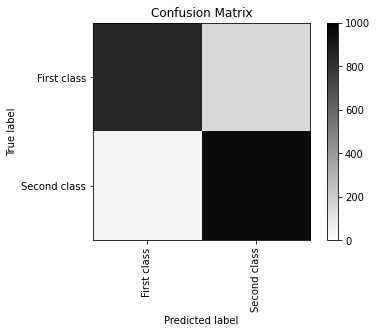

In [74]:
y_MLE_pred = naive_bayses_maximum_likelihood(X_train.x, y_train, X_test.x)
draw_confusion_matrix(y_test, y_MLE_pred)

### Выводы

Для всех реализуемых методов мы получаем примерно одинаковые результаты, в которых 1 класс детектируется лучше, чем второй. Не идеальное оно потому, что есть пересечения.

## Задание3. Исследование доноров крови

[2 балла] (данные реальные) В одном исследовании доноров крови в Китае
выяснилось, что примерно у 1 из 100 000 из них есть ВИЧ (согласно очень
надёжному основательному тесту). Для первоначального скрининга доноров
использовался быстрый тест, который имеет чувствительность 99.7% и
специфичность 99.8%, то есть если у человека есть ВИЧ, то тест будет
положительным с вероятностью 99.7%, а если у человека нет ВИЧ, то тест будет отрицательным с вероятностью 99.8%. Если этот первоначальный тест дал
положительный результат, то какова вероятность, что у донора есть ВИЧ?
Сначала прикиньте как вам кажется интуитивно и запишите ваш интуитивный
ответ, а потом выведите ответ математически.

Интуитивно тяжело дать ответ, зная формулу. Но если рассуждать без мысли о формулах, то хотелось бы дать ответ 99.7%. 

In [21]:
TP = 0.997
TN = 0.998
FN = 1 - TN
FP = 1 - TP
count_positive = 1
percent_positive = 1/100000
percent_negative = 1 - percent_positive

probability_all = FN * percent_negative + TP * count_positive
print(f"Если этот первоначальный тест дал положительный результат, то с вероятностью {round(probability_all*100, 4)}% у донора есть ВИЧ")

Если этот первоначальный тест дал положительный результат, то с вероятностью 99.9% у донора есть ВИЧ
